In [1]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

Represent time series as `np array`.

In [60]:
import numpy as np
# l = 2
q = np.array([1,1,1,2,2,3,3,4]) #|q|=m=8
c = np.array([1,1,1,1,2,3,3,3,4,4,5,6,7]) #|c|=n=13
# k ranges from m/l = 8/2 = 4 to min(lm,n) = min(2*8,13) = 13 (i.e, k = 4..13)
# L = 13

In [61]:
c_1_10 = c[1:10]
c_1_10

array([1, 1, 1, 2, 3, 3, 3, 4, 4])

Some time series examples from library.
They are represented in `series`.

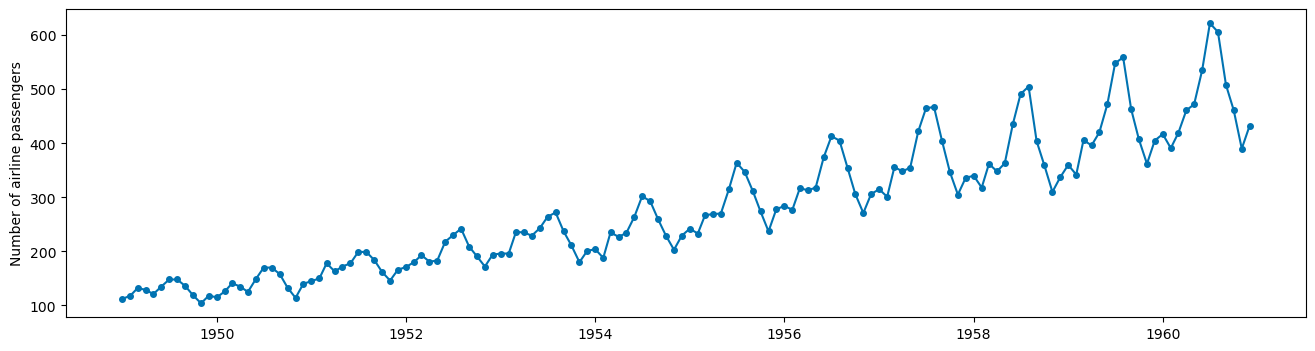

In [62]:
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
y = load_airline()
fig, ax = plot_series(y)  

Another example. Also in `series`.

In [63]:
import pandas as pd
# https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q1 = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c1 = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))

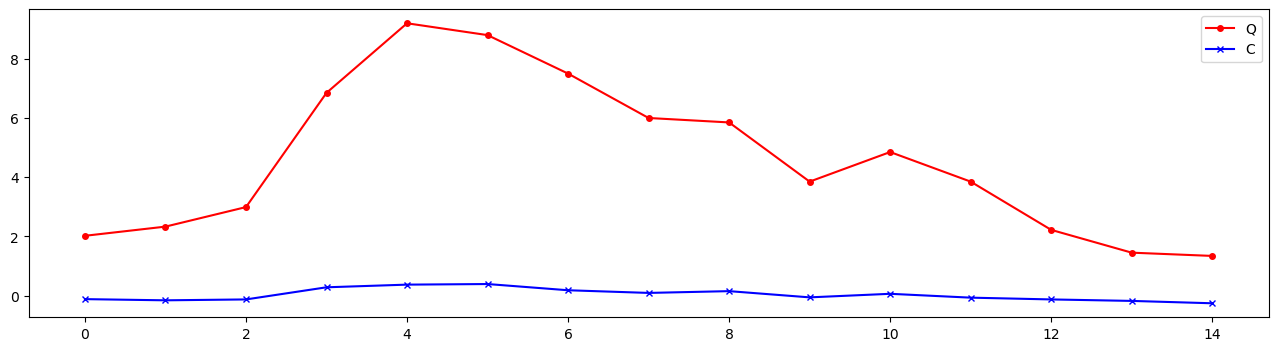

In [64]:
from sktime.utils.plotting import plot_series
fig, ax = plot_series(q1, c1, markers=["o", "x"], colors=["red", "blue"], labels=["Q", "C"]) 


# 3 Preliminaries and Problem Statement

##  Z-normalization

A simple Z-normalization function

In [65]:
import numpy as np
def normalize(ts):
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std

In [66]:
normalize(q)

array([-1.06810349, -1.06810349, -1.06810349, -0.11867817, -0.11867817,
        0.83074716,  0.83074716,  1.78017249])

In [67]:
normalize(q1)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64

In [68]:
def normalize_series(series):
    mean = series.mean()  # Calculate the mean
    std = series.std(ddof=0) # Calculate the population standard deviation instead of the default sample standard deviation
    
    # Apply z-normalization formula: (x - mean) / std
    normalized_series = (series - mean) / std
    
    return normalized_series

In [69]:
normalize_series(q)

array([-1.06810349, -1.06810349, -1.06810349, -0.11867817, -0.11867817,
        0.83074716,  0.83074716,  1.78017249])

In [70]:
normalize_series(q1)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64

These two self-implemented normalizer works well both for `np array` and `series`

In [71]:
q1_znorm = normalize(q1)
print(q_znorm)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64


Standard Z-normalizer from library

In [72]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def z_normalize(series):
    # Reshape the series to 2D (required by StandardScaler)
    reshaped = series.values.reshape(-1, 1)
    
    # Apply z-normalization
    scaler = StandardScaler()
    normalized = scaler.fit_transform(reshaped)
    
    # Convert back to pandas Series
    return pd.Series(normalized.flatten(), index=series.index)

In [73]:
q1_znorm = z_normalize(q1)
print(q_znorm)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64


The results are the same!

In [46]:
# z_normalize(q)

z_normalize only works for `series` but not `np array`.

In [74]:
c1_znorm = normalize(c1)


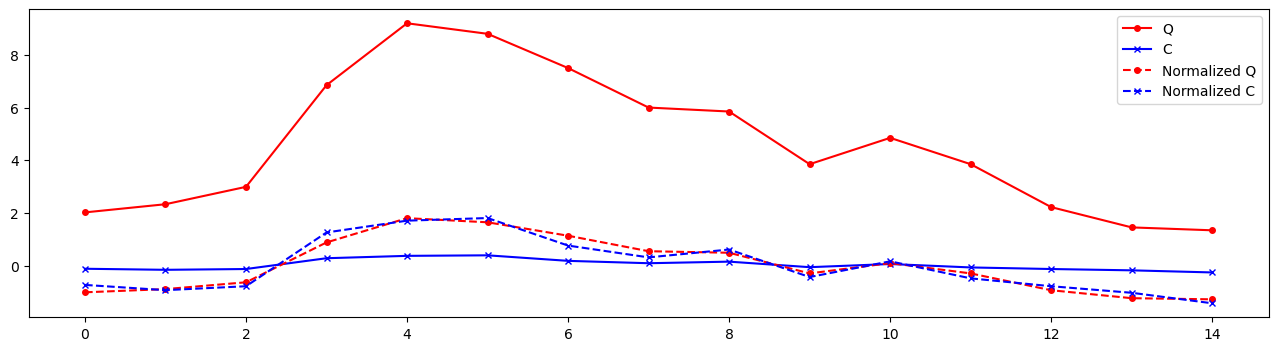

In [75]:
import matplotlib.pyplot as plt
fig, ax = plot_series(q1, c1, q1_znorm, c1_znorm, markers=["o", "x", "o", "x"], colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) 
ax.lines[2].set_linestyle("--")  # Dashed line for the first series
ax.lines[3].set_linestyle(("--"))   # Dotted line for the second series
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
ax.legend()
plt.show()

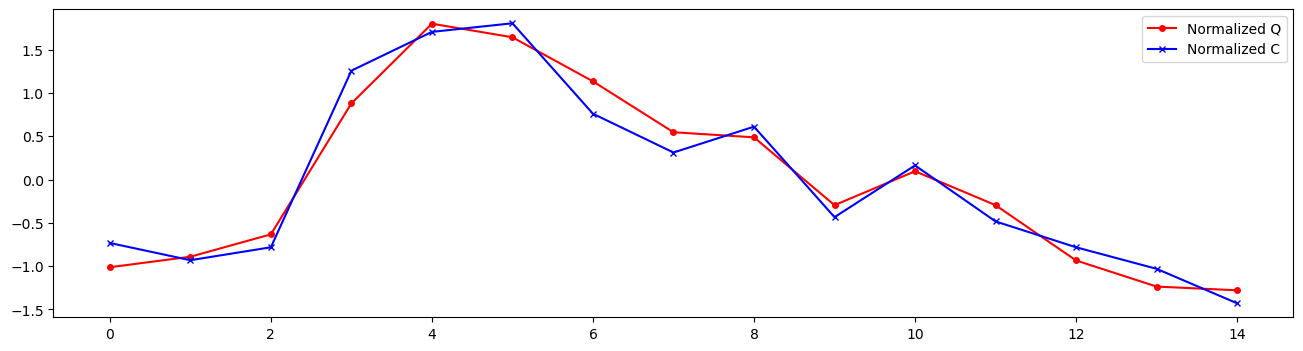

In [76]:
fig, ax = plot_series(q1_znorm, c1_znorm, markers=["o", "x"], colors=["red", "blue"], labels=["Normalized Q", "Normalized C"]) 
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
ax.legend()
plt.show()

## ED, Squared ED, DTW

In [ ]:
# Oridinary ED
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html
import numpy as np
from sktime.distances import euclidean_distance
euclidean_distance(q1.to_numpy(), c1.to_numpy()), euclidean_distance(q1_znorm.to_numpy(), c1_znorm.to_numpy())

(19.942780648645765, 0.7986926618401663)

In [ ]:
# Squared ED
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.squared_distance.html
from sktime.distances import squared_distance
squared_distance(q1_znorm.to_numpy(), c1_znorm.to_numpy())

0.6379099680773302

In [ ]:
# DTW
import numpy as np
from sktime.distances import dtw_distance
dtw_distance(q1_znorm.to_numpy(), c1_znorm.to_numpy())

0.6379099680773301

## Interpolation

In [77]:
from scipy.ndimage import zoom
def nearest_neighbor_interpolate(ts, new_length):
    # order = 0 for nearest neighbor interpolation
    return zoom(ts, new_length/len(ts), order=0)


In [78]:
q, c, c_1_10, len(q), len(c), len(c_1_10)

(array([1, 1, 1, 2, 2, 3, 3, 4]),
 array([1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 5, 6, 7]),
 array([1, 1, 1, 2, 3, 3, 3, 4, 4]),
 8,
 13,
 9)

In [79]:
test = nearest_neighbor_interpolate(q, 10)
test, len(test)

(array([1, 1, 1, 1, 2, 2, 3, 3, 3, 4]), 10)

## 3.3 Uniform Scaling (US)

In [80]:
# import numpy as np
import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
# from dtaidistance import dtw
# from scipy.stats import pearsonr
# import pandas as pd

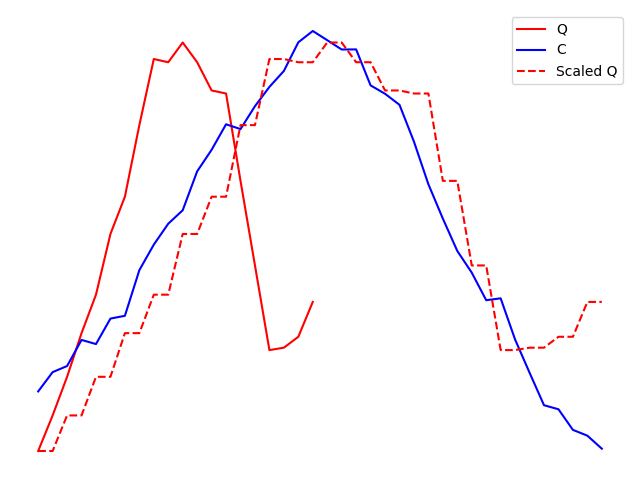

In [130]:
np.random.seed(0)
q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
c = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
q_scaled = nearest_neighbor_interpolate(q, len(c))

q = normalize(q)
c = normalize(c)
q_scaled = normalize(q_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(q, label='Q', color='red')
ax1.plot(c, label='C', color='blue')
ax1.plot(q_scaled, label='Scaled Q', linestyle='--', color='red')

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis('off')
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()


Another example

In [123]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 50)
c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])


In [124]:
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100

In [125]:
m = len(q)
n = len(c)
print(m, n)

70 150


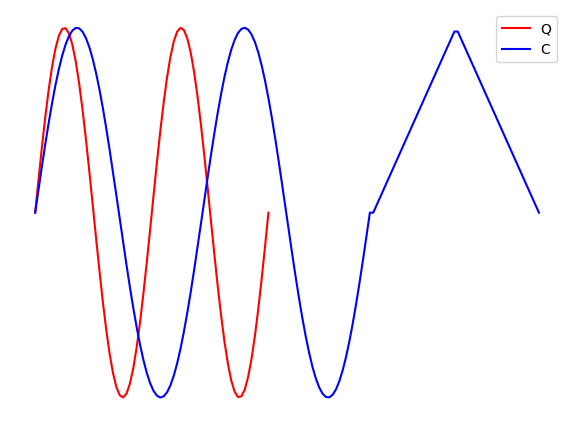

In [129]:
plt.plot(q, color='red', label='Q')
plt.plot(c, color='blue', label='C')
# plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# https://stackoverflow.com/questions/66934748/how-to-stretch-an-array-to-a-new-length-while-keeping-same-value-distribution
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

In [ ]:
c_prefix = c[:100]

In [ ]:
c_prefix_interpolated = interp1d(c_prefix, new_len=len(q))

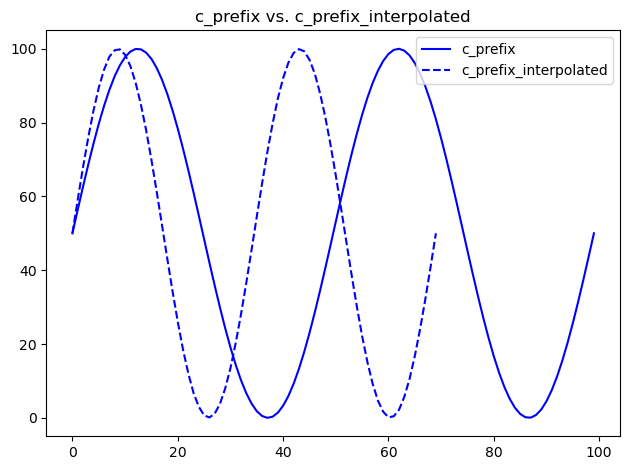

In [ ]:
plt.plot(c_prefix, color='blue', label='c_prefix')
plt.plot(c_prefix_interpolated, linestyle='--', color='blue', label='c_prefix_interpolated')
plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
len(c_prefix), len(c_prefix_interpolated)

(100, 70)

In [ ]:
euclidean_distance(q, c_prefix_interpolated)

0.4318021168070545

In [ ]:
l = 2 # scaling_factor 

In [ ]:
# US
import math
best_so_far = np.inf
for k in range(math.ceil(m/l), min(l*m, n)):
    c_prefix = c[:k]   
    c_prefix_interpolated = interp1d(c_prefix, new_len=m)
    dtw_distance
    us_dist = euclidean_distance(q, c_prefix_interpolated)
    # us_dist = dtw_distance(q, c_prefix_interpolated)
    if us_dist < best_so_far:
        best_so_far = us_dist
        best_k = k


In [ ]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(0.4318021168070545, 100, 142.85714285714286)

In [ ]:
# US + DTW
best_so_far = np.inf
for k in range(math.ceil(m/l), min(l*m, n)):
    c_prefix = c[:k]   
    c_prefix_interpolated = interp1d(c_prefix, new_len=m)
    dtw_distance
    dtw_dist = dtw_distance(q, c_prefix_interpolated)
    if dtw_dist < best_so_far:
        best_so_far = dtw_dist
        best_k = k

In [ ]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(0.18645306807905324, 100, 142.85714285714286)

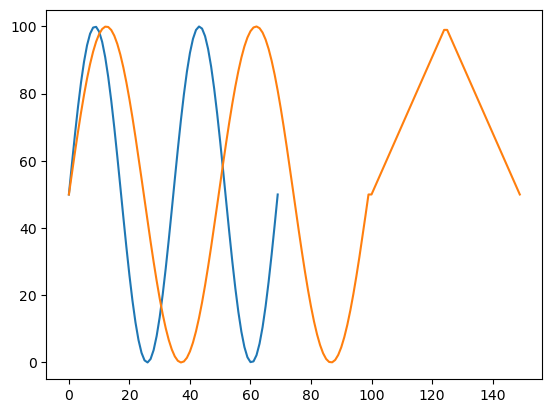

In [ ]:
plt.plot(q)
plt.plot(c)

In [ ]:
dtw_distance(q, c)

41157.42316279798

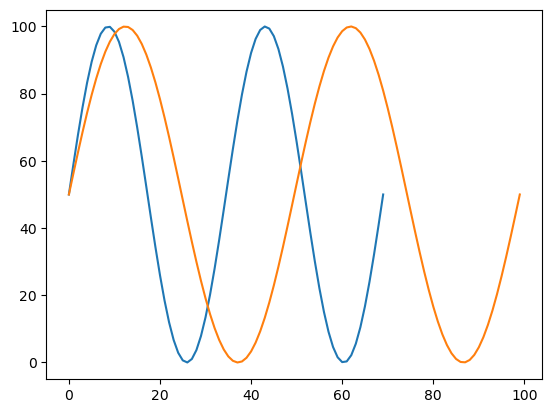

In [ ]:
plt.plot(q)
plt.plot(c[:100])

In [ ]:
dtw_distance(q, c[:len(q)])

72896.27205022328

In [ ]:
dtw_distance(q, c[:100])

341.09663218572496

## 3.2 Dynamic Time Warping (DTW)

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


dtw_sakoechiba: 2.1256387200688422
dtw_itakura: 2.3393233353190075


/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


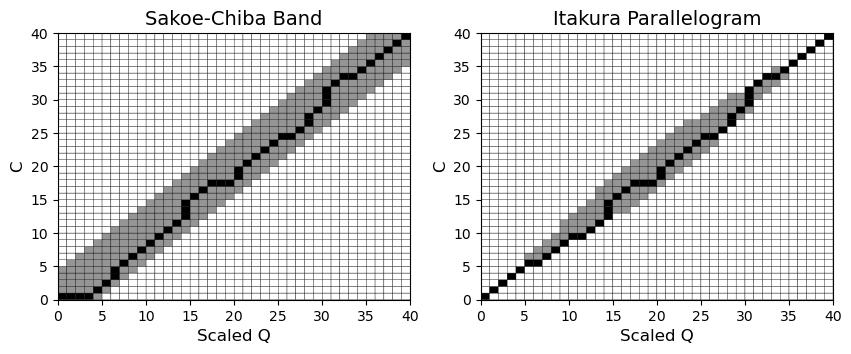

In [82]:
x = q_scaled
y = c

# https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

# Parameters
# X, _, _, _ = load_gunpoint(return_X_y=True)
# x, y = X[0], X[1]
# To compare time series of different lengths, we remove some observations
# mask = np.ones(x.size)
# mask[::5] = 0
# y = y[mask.astype(bool)]
n_timestamps_1, n_timestamps_2 = x.size, y.size

plt.figure(figsize=(10, 8))
timestamps_1 = np.arange(n_timestamps_1 + 1)
timestamps_2 = np.arange(n_timestamps_2 + 1)

# Dynamic Time Warping: sakoechiba
window_size = 0.1
dtw_sakoechiba, path_sakoechiba = dtw(
    x, y, dist='square', method='sakoechiba',
    options={'window_size': window_size}, return_path=True
)
band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                        window_size=window_size)
matrix_sakoechiba = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

plt.subplot(2, 2, 1)
plt.pcolor(timestamps_1, timestamps_2, matrix_sakoechiba.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('Scaled Q', fontsize=12)
plt.ylabel('C', fontsize=12)
plt.title('Sakoe-Chiba Band', fontsize=14)
print("dtw_sakoechiba:", dtw_sakoechiba)

# Dynamic Time Warping: itakura
slope = 1.2
dtw_itakura, path_itakura = dtw(
    x, y, dist='square', method='itakura',
    options={'max_slope': slope}, return_path=True
)
parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                      max_slope=slope)
matrix_itakura = np.zeros((n_timestamps_1, n_timestamps_2))
for i in range(n_timestamps_1):
    matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
matrix_itakura[tuple(path_itakura)] = 1.
plt.subplot(2, 2, 2)
plt.pcolor(timestamps_1, timestamps_2, matrix_itakura.T,
           edgecolors='k', cmap='Greys')
plt.xlabel('Scaled Q', fontsize=12)
plt.ylabel('C', fontsize=12)
plt.title("Itakura Parallelogram",
          fontsize=14)
print("dtw_itakura:", dtw_itakura)

# plt.suptitle("Dynamic Time Warping", y=0.995, fontsize=17)
plt.subplots_adjust(top=0.91, hspace=0.4)
plt.savefig("../figures/dtw-matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()


# 4 Piecewise Scaling & Dynamic Time Warping (PSDTW)

# ---

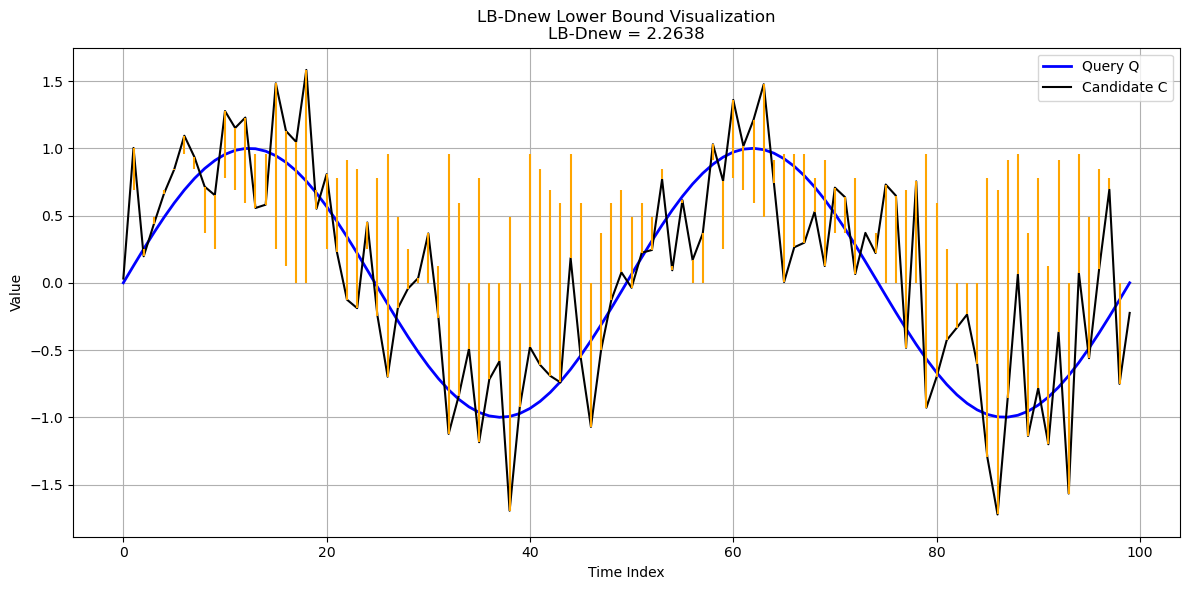

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def lb_dnew(q, c, r):
    n = len(c)
    m = len(q)
    dist = lambda a, b: (a - b)**2

    total = dist(q[0], c[0]) + dist(q[-1], c[-1])
    window_contrib = []

    for j in range(1, n - 1):
        start = max(0, j - r)
        end = min(m, j + r + 1)
        local_window = q[start:end]
        min_dist = np.min([dist(c[j], qk) for qk in local_window])
        window_contrib.append((j, min_dist))
        total += min_dist

    return total, window_contrib

def plot_lb_dnew(q, c, r):
    lb, contribs = lb_dnew(q, c, r)
    x = np.arange(len(c))

    plt.figure(figsize=(12, 6))
    plt.plot(q, label="Query Q", color="blue", linewidth=2)
    plt.plot(c, label="Candidate C", color="black", linewidth=1.5)

    # Red vertical bars showing min distance from c[j] to q[j±r]
    for j, min_d in contribs:
        if min_d > 0:
            closest_q_val = q[np.argmin([abs(c[j] - qk) for qk in q[max(0, j - r):min(len(q), j + r + 1)]])]
            plt.vlines(j, c[j], closest_q_val, color='orange', linewidth=1.5)

    plt.title(f"LB-Dnew Lower Bound Visualization\nLB-Dnew = {np.sqrt(lb):.4f}")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

plot_lb_dnew(q, c, r=5)


In [3]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [4]:
def lb_shen_argmin_q(q, c, r):
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b)**2

    # total = dist(q[0], c[0]) + dist(q[-1], c[-1])
    window_contrib = []
    # window_contrib.append((0, 0)) 
    window_contrib.append(q[0]) 
    

    for j in range(1, n - 1):
        start = max(0, j - r)
        end = min(m, j + r + 1)
        q_window = q[start:end]
        argmin = np.argmin([dist(c[j], qk) for qk in q_window]) #qk = q_argmin
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        # total += min_dist
    window_contrib.append(q[-1]) 
    return window_contrib

100
100


NameError: name 'numpy' is not defined

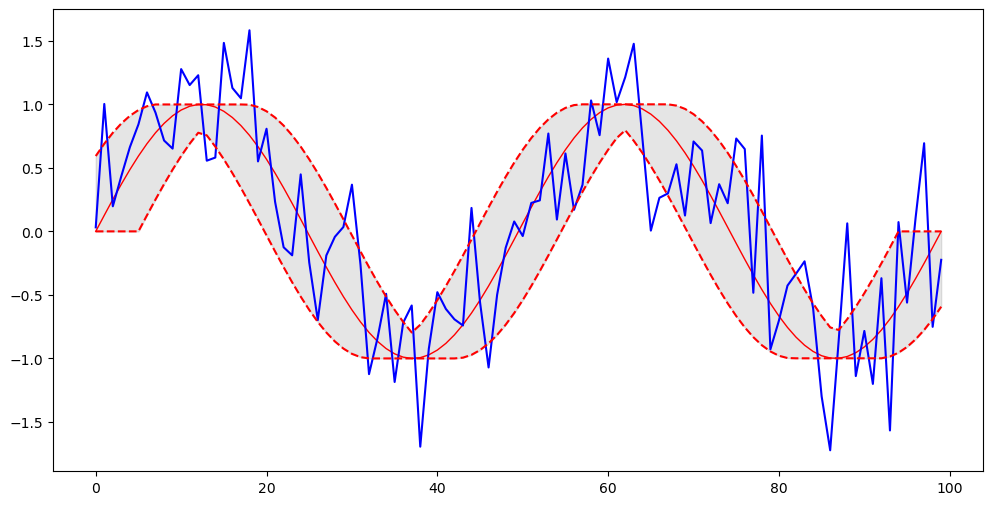

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def lb_keogh_envelope(ts, radius):
    n = len(ts)
    upper = np.zeros(n)
    lower = np.zeros(n)
    for i in range(n):
        start = max(0, i - radius)
        end = min(n, i + radius + 1)
        lower[i] = np.min(ts[start:end])
        upper[i] = np.max(ts[start:end])
    return lower, upper

def lb_keogh(ts_query, ts_candidate, radius):
    lower, upper = lb_keogh_envelope(ts_query, radius)
    lb_sum = 0
    for i in range(len(ts_candidate)):
        if ts_candidate[i] > upper[i]:
            lb_sum += (ts_candidate[i] - upper[i])**2
        elif ts_candidate[i] < lower[i]:
            lb_sum += (ts_candidate[i] - lower[i])**2
    return np.sqrt(lb_sum)


def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label='Q', color='red', linewidth=1)
    plt.plot(x, c, label='C', color='blue', linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label='$Q^U$', linestyle='--', color='red', linewidth=1.5)
    plt.plot(x, lower, label='$Q^L$', linestyle='--', color='red', linewidth=1.5)
    plt.fill_between(x, lower, upper, color='gray', alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

    print(len(lower))
    test = lb_shen_argmin_q(q, c, r=5)
    print(len(np.array(test)))
    plt.vlines(numpy.arange(len(q)), c, test,
           label='Additional Partial distance to $LB_{Shen}$', color='black', linewidth=3.0)
    # Elegant version
    plt.vlines(numpy.arange(len(q)), c, numpy.clip(c, lower, upper),
           label='Partial distance to $LB_{Keogh}$', color='green', linewidth=3.0)

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc='lower left')
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()



plot_lb_keogh_full(q, c, radius=5)


In [136]:
test = lb_shen_argmin_q(q, c, r=5)

NameError: name 'lb_shen_argmin_q' is not defined

In [66]:
test

[np.float64(0.690079011482112),
 np.float64(0.2511479871810792),
 np.float64(0.4861967361004687),
 np.float64(0.690079011482112),
 np.float64(0.8497254299495144),
 np.float64(0.984807753012208),
 np.float64(0.9549022414440739),
 np.float64(0.690079011482112),
 np.float64(0.690079011482112),
 np.float64(0.998867339183008),
 np.float64(0.998867339183008),
 np.float64(0.998867339183008),
 np.float64(0.7557495743542583),
 np.float64(0.6667690005162916),
 np.float64(0.998867339183008),
 np.float64(0.998867339183008),
 np.float64(0.998867339183008),
 np.float64(0.9968547759519424),
 np.float64(0.5670598638627709),
 np.float64(0.8325698546347714),
 np.float64(0.2203105327865408),
 np.float64(-0.15800139597335008),
 np.float64(-0.15800139597335008),
 np.float64(0.4582265217274105),
 np.float64(-0.28173255684142984),
 np.float64(-0.7126941713788629),
 np.float64(-0.15800139597335008),
 np.float64(-0.03172793349806786),
 np.float64(0.09505604330418244),
 np.float64(-0.03172793349806786),
 np.flo

In [107]:
from dtaidistance import dtw
import numpy as np
s1 = np.array([0.0, 0, 1, 2, 1, 0, 1, 0, 0])
s2 = np.array([0.0, 1, 2, 0, 0, 0, 0, 0, 0])
d = dtw.distance_fast(s1, s2)
d

1.4142135623730951

In [108]:
import warnings

from aeon.distances import dtw_distance, euclidean_distance
# https://www.aeon-toolkit.org/en/stable/examples/distances/distances.html
warnings.filterwarnings("ignore")
time_series_a = np.array([1, 2, 3, 4, 5, 6]) 
time_series_b = np.array([2, 2, 4, 4, 6, 6])
c = np.array([2, 4, 6])


In [109]:
d1 = euclidean_distance(time_series_a, time_series_b)
d2 = dtw_distance(time_series_a, time_series_b)
print(f" ED = {d1} DTW = {d2}")

 ED = 1.7320508075688772 DTW = 3.0


In [110]:
from aeon.distances import dtw_cost_matrix
m = dtw_cost_matrix(time_series_a, time_series_b)
# https://www.askpython.com/python/array/reverse-an-array-in-python
m = np.flipud(m)
m

array([[31., 31.,  7.,  7.,  3.,  3.],
       [15., 15.,  3.,  3.,  3.,  4.],
       [ 6.,  6.,  2.,  2.,  6., 10.],
       [ 2.,  2.,  2.,  3., 12., 21.],
       [ 1.,  1.,  5.,  9., 25., 41.],
       [ 1.,  2., 11., 20., 45., 70.]])

In [111]:
print(dtw_distance(q,c_1_10))

236191.47428739603


In [112]:
import math
def compute_US(q,c,l,L):
    current_min = float('inf')
    for i in range(math.ceil(len(q)/L), min(math.ceil(L*len(q)), len(c))):
            d = euclidean_distance(nearest_neighbor_interpolate(c[:i],L), nearest_neighbor_interpolate(q,L))
            if d < current_min:
                current_min = d
    return current_min


In [113]:
q = np.array([1,1,1,2,2,2])
c = np.array([1,1,1,1,2,2,2,2,5,6,7])

In [114]:
l = 2
L = min(math.ceil(l*len(q)),len(c))

In [115]:
ans = compute_US(q,c,l,L)
print(ans)
print(dtw_distance(q,c[:8]))

0.0
0.0


In [ ]:
###

In [116]:
time_series_a = time_series_a_scaled

NameError: name 'time_series_a_scaled' is not defined

In [ ]:
distance, paths = dtw.warping_paths(time_series_a, time_series_b, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

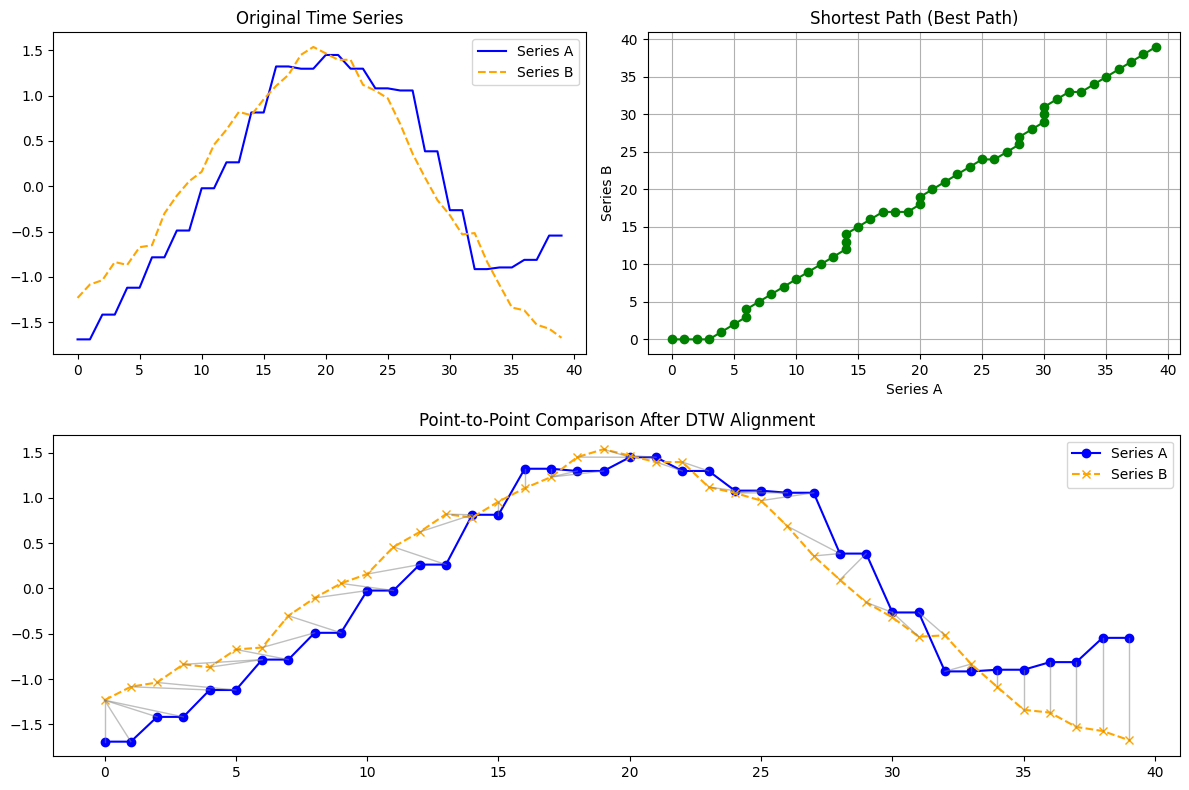

In [ ]:
# https://medium.com/@markstent/dynamic-time-warping-a8c5027defb6
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score]
})

results_df['Description'] = [
    "Lower scores indicate greater similarity between the time series."
]

results_df

,Metric,Value,Description
0,DTW Similarity Score,0.045226,Lower scores indicate greater similarity betwe...


In [ ]:
print(euclidean_distance(time_series_a, time_series_b))

2.747670853922536


In [ ]:
print(dtw_distance(time_series_a, time_series_b))

4.518339968255907


In [ ]:
print(f" distance = {distance} length of path = {len(best_path)} ration = {distance/len(best_path)}")

 distance = 2.1256387200688422 length of path = 47 ration = 0.04522635574614558


In [ ]:
###

In [117]:
from dtaidistance import dtw
s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0, 1, 2, 0, 0, 0, 0, 0, 0]
distance = dtw.distance(s1, s2)
print(distance)
s1 = np.array([0, 0, 1, 2, 1, 0, 1, 0, 0]) 
s2 = np.array([0, 1, 2, 0, 0, 0, 0, 0, 0]) 
print(dtw_distance(s1, s2))

1.4142135623730951
2.0


In [ ]:
###

In [118]:
s1 = [10794.800, 125.763, 195.8140, 790.387]
s2 = [1598.520, 260.395, 326.97900, 1144.470]

In [119]:
distance, paths = dtw.warping_paths(s1, s2, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

In [120]:

print(len(best_path))
print(distance)

4
9205.013342844104
